<a href="https://colab.research.google.com/github/ahhyun-moon/cs-gy-6613-assignments/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Env setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Read data in google drive
# Downloaded from: https://www.kaggle.com/competitions/avazu-ctr-prediction/data
df = pd.read_csv('/content/drive/MyDrive/avazu-ctr-prediction/train.gz'\
                 ,compression='gzip',nrows=1000000)

In [ ]:
# 2-0. Data preprocessing

# Drop id and duplicates.
clean_df = df.drop(['id'], axis=1).drop_duplicates()

# Convert YYMMDDHH data to hour value
clean_df['hour'] = clean_df['hour'].map(lambda x: datetime.strptime(str(x),"%y%m%d%H"))
clean_df['hour'] = clean_df['hour'].map(lambda x:  x.hour)

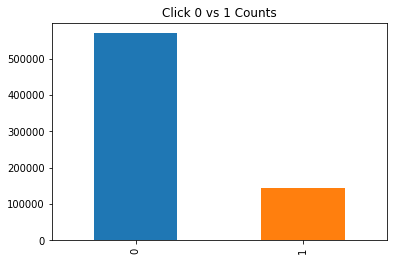

In [ ]:
# 2-1. Data preprocessing (Target)

### Assumptions:
# Target variable (click) follows Bernoulli Distribution which has 2 outcomes (0/1).
# Therefore, we can use logistic regression model to classify the target into 0 or 1.
# We can see that data is highly imbalanced. Almost 85% of click is 0 and only 15% is 1.
# Later we can take either undersample, or oversample approach for this issue. 
clean_df.click.value_counts().plot.bar(color={"C0":0,"C1":1})
plt.title("Click 0 vs 1 Counts")
plt.show()

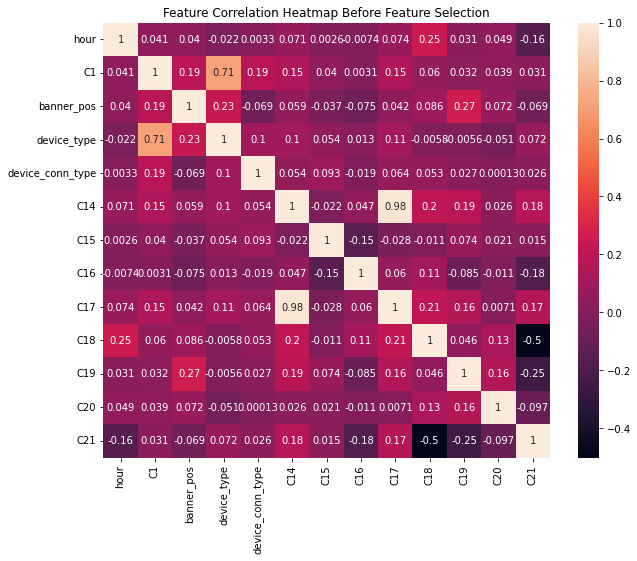

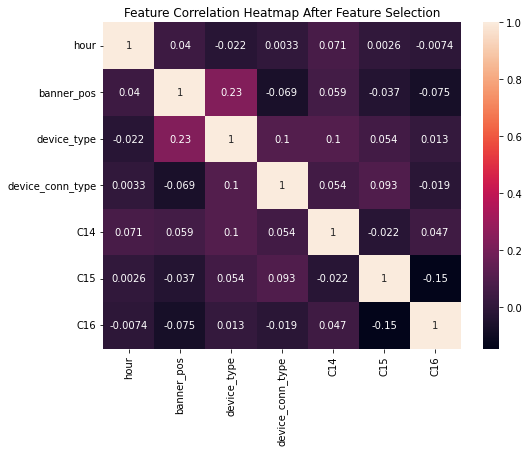

In [ ]:
# 2-2. Data preprocessing (Feature)

# Create 'features' dataframe by excluding target variable (click)
features = clean_df.drop(['click'], axis=1)

# Show correlations as heatmap.
plt.figure(figsize=(10,8))
plt.title("Feature Correlation Heatmap Before Feature Selection")
sns.heatmap(features.corr(), annot=True)
plt.show()

# C1 and device_type are highly co-related -> Drop C1
#   C1 is anonymized while device_type is interpretable
# C14 and C17 highly co-related -> Drop C17
#   Tested both columns and yielded better prediction score with C14 
# Drop additional columns that have low/no correlation.
features = features.drop(['site_id', 'site_domain', 'site_category', 'app_id',\
                          'app_domain', 'app_category','device_ip', 'device_id',\
                          'device_model','C1','C17','C18','C19','C20','C21'], axis=1)

# Show correlations heatmap after feature selection.
plt.figure(figsize=(8,6))
plt.title("Feature Correlation Heatmap After Feature Selection")
sns.heatmap(features.corr(), annot=True)
plt.show()

### Now we have target and features as below:
# Target variable: 'click'
# Continuous Feature: 'hour','
# Discrete Features: banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16'

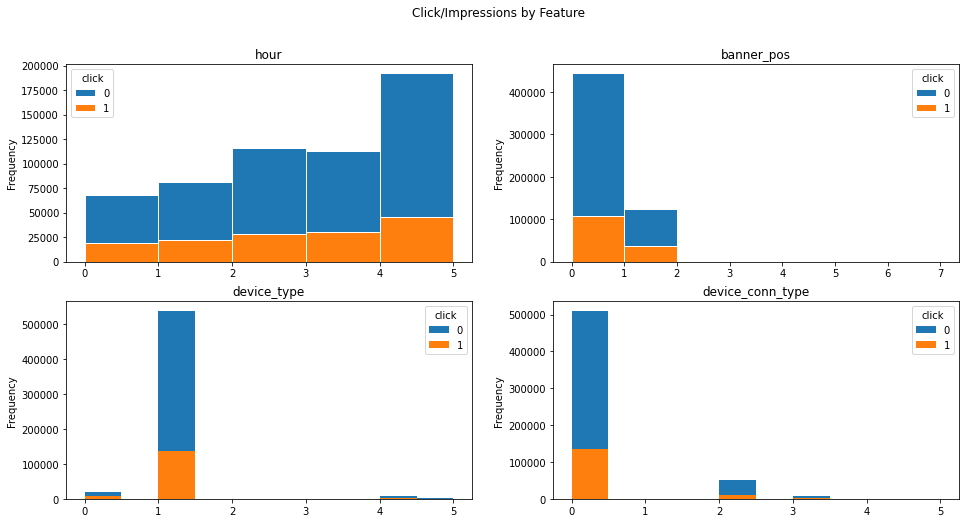

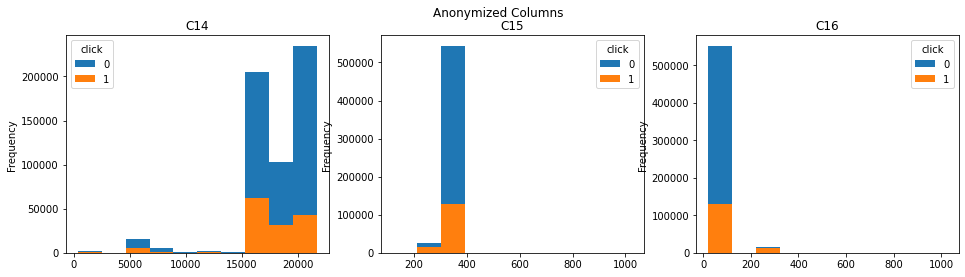

In [ ]:
# 2-3. Data preprocessing (Experiments)

# Draw histograms to analyze relationship between click and each feature.
fig,ax=plt.subplots(2,2,figsize=(16,8))
fig.suptitle("Click/Impressions by Feature")
clean_df.pivot(columns='click', values='hour').plot.hist(ax=ax[0,0], title='hour', bins=[h for h in sorted(clean_df['hour'].unique())],edgecolor='white')
clean_df.pivot(columns='click', values='banner_pos').plot.hist(ax=ax[0,1], title='banner_pos', bins=[h for h in sorted(clean_df['banner_pos'].unique())],edgecolor='white')
clean_df.pivot(columns='click', values='device_type').plot.hist(ax=ax[1,0], title='device_type')
clean_df.pivot(columns='click', values='device_conn_type').plot.hist(ax=ax[1,1], title='device_conn_type')
plt.show()
fig,ax=plt.subplots(1,3,figsize=(16,4))
fig.suptitle("Anonymized Columns")
clean_df.pivot(columns='click', values='C14').plot.hist(ax=ax[0], title='C14')
clean_df.pivot(columns='click', values='C15').plot.hist(ax=ax[1], title='C15')
clean_df.pivot(columns='click', values='C16').plot.hist(ax=ax[2], title='C16')
plt.show()

In [ ]:
# 2.4 Data standardizing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Randomly undersample the training data to avoid data imbalance.
underSample = RandomUnderSampler()   
X, y = underSample.fit_resample(features, clean_df['click'])

# Using train_test_split, break the dataset into two parts in ratio of 70:30,
# 70% of data will be used for model training and 30% for model testing.
X_train, X_test, y_train, y_test\
= train_test_split(X, y, test_size=0.3, random_state = 15)

# Standardize features by removing the mean and scaling to unit variance,
# so that each feature will have mean of 0 and standard deviation of 1.
# z = (x - u) / s
# Difference in scale can affect the step size of the gradient descent.
# The model will be trained with standardized data so we are also scaling the test data.  
scaler = StandardScaler()
x_train_standard = scaler.fit_transform(X_train)
x_test_standard = scaler.transform(X_test)  

In [ ]:
# 3. Logistic Regression
from sklearn.linear_model import LogisticRegression

# Logistic Regression function fits the data to sigmoid(z) = 1/(1 + exp(-z)), 
# by taking an instance x and calculating the likelihood of a binary outcome occurring.
# Then it trains the model with SGD and binary cross entropy (−(𝐲𝑙𝑜𝑔(𝐳)+(1−𝐲)𝑙𝑜𝑔(1−𝐳))). 
# Binary cross entropy tells the distance(loss) of each output(of sigmoid) from actual result.
# SGD iteratively updates the model for minimum loss.

lr = LogisticRegression()
lr.fit(x_train_standard, y_train)
# The gradient of the loss function can bee seen as the slope of SGD, telling which direction to move. 
print(f"Coef: {lr.coef_}") 

# From the score, we can assume the model is underfitting.
# The model is too simple and unable to capture the relationship 
# between its input features and target values. 
# To improve the model, we can increase training and add complexity by regularization.  
print("Score: ", lr.score(x_test_standard, y_test))

Coef: [[-0.03695103  0.12861539 -0.10613821 -0.08108036 -0.24592814 -0.03273142
   0.29115093]]
Score:  0.5818582284903767


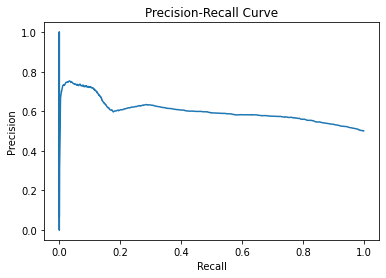

In [ ]:
# 4. Performance Results
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# Precision = number of true positives / (true positives + false positives)
# Represents how well the model predicts the positive class.
# Recall = number of true positives / (true positives + false negatives)
# Represents sensitivity. 
# If you increase precision, it will reduce recall, and vice versa.

# Get Y prediction on x_test_standard, based on the model. 
y_pred = lr.predict(x_test_standard)
y_probs = lr.predict_proba(x_test_standard)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

# Draw precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
plt.show()